# model regularization to mitigate overfitting

Model overfitting can often be associated with very 'extreme' values of fitted model parameters. When model parameter values become highly positive or highly negative, the model can tend to react very 'strongly' to particular inputs, potentially causing lack of generalizability to new data.

Statisticians have long used model "regularization" to help control overfitting by 'penalizing' extreme values of model parameters. Regularization is extremely popular in the 'machine learning' world, forming the foundation for methods like "lasso" and "ridge" regression. Model regularization is also a very common technique used in neural network modeling.

The two most commonly-used model regularization penalties are:

*  L1 regularization
*  L2 regularization

The names are actually more 'informative' than you might think. Both methods apply an increasing 'penalty' on the model's loss function as the sum of the model's parameters gets farther away from zero, either positively or negatively.

L1 regularization's penalty scales as the *absolute value* of the model's parameter value, so the L1 term scales *linearly* with 'increasing' model parameter values.

L2 regularization's penalty scales as the *square* of the model's parameter value. You can remember it because L2 has a "2" in it, for 'squared'.

Practically, L2 regularization applies a much *stronger* penalty as the model's parameter value gets very large (either positively or negatively), while applying a much *weaker* penalty when the parameter value is less than 1. For this reason, L2 regularization tends to produce models with many small parameter values and few values that are zero, compared to L1 regularization, which tends to produce 'sparse' models in which many parameter values are zero.

In neural networks, model regularization can be applied in any of 3 different ways:

*  kernel regularization - penalizes the neuron's *weights*
*  bias regularization - penalizes the neuron's *bias term*
*  activity regularization - penalizes the neuron's *output*

As a neural network designer, you can apply any or all of these regularization penalties to any or all of the layers in your network.

Probably the most common approach is to apply kernel regularization (penalizing the neruon's weights) to all layers in the network *except* the output layer, which is typically *not* regularized.

To use model regularization, you need to specify the "regularization_factor", which is a number multiplied by the regularization term to control the *strength* of regularization. Mathematically:

    total_loss = loss + regularization_factor * regularization_term

you calculate the "regularization_term", based on the model's parameter values and the type of regularization being used (typically L1 or L2). Multiply the regularization_term by the user-specified regularization_factor, and then add this to the model's "loss" to get the total_loss.

Commonly-used regularization factors are typically in the range of 0.01 or 0.001, but they can vary greatly, depending on the model being developed. Typically you will 'tweak' the regularization factor until you've reduced overfitting to an 'acceptable' amount.

In this notebook you will implement L1 and L2 kernel regularization and observe its impact on model overfitting in an example problem.

In the below code cell, we simulate a linear data set of 100 samples with 2 explanatory variables and a single response variable.

We split the data set into 60% training and 40% validation data, and we train a complex neural network for 500 epochs using a batch size of 10, stochastic gradient descent optimization and mean squared error loss.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8577 (33.50 KB)
Trainable params: 8577 (33.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
6/6 [==============================] - 3s 86ms/step - loss: 1.3227 - val_loss: 1.1017
Epoch 2/500
6/6 [==============================] - 0s 13

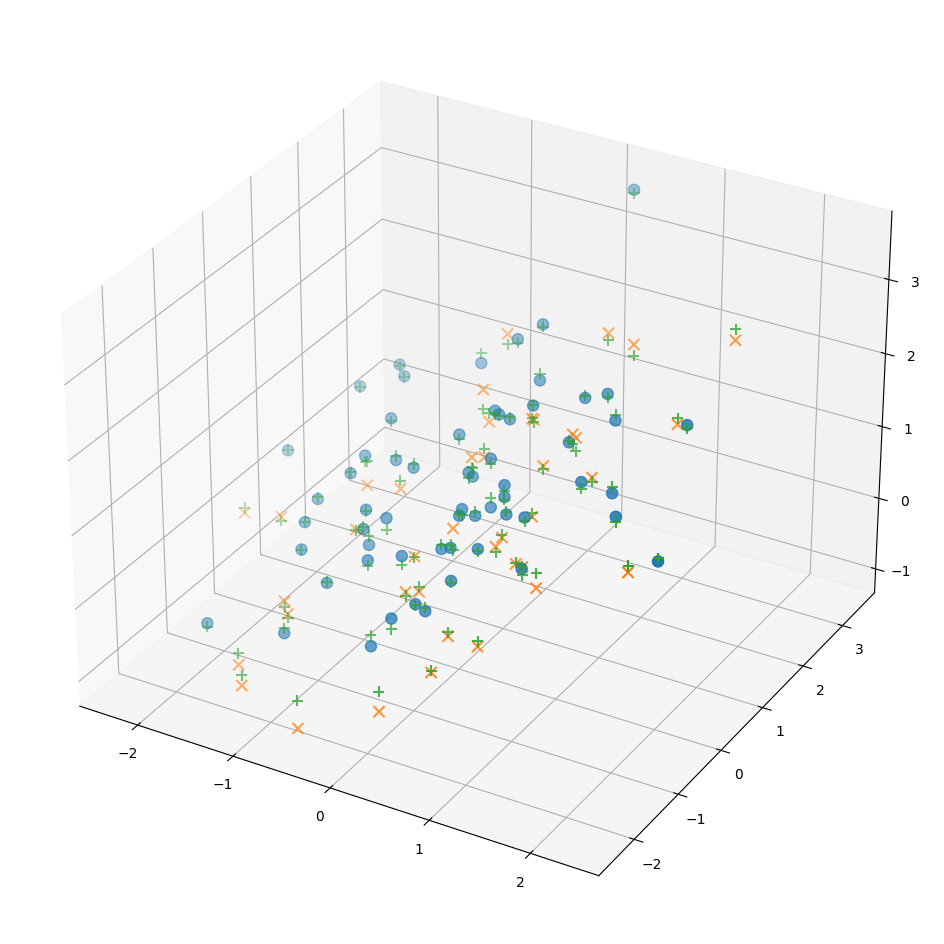

In [1]:
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate data
x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=2,
                                       bias=100.0,
                                       noise=10.0,
                                       random_state=201188)
y /= 100.0

# partition into train and validation subsets
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,
                                                                              y,
                                                                              test_size=40,
                                                                              random_state=221882)

# package training and validation data into tensorflow Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(10)

# build model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, input_shape=[2]))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

# fit model
model.fit(train_data, epochs=500, validation_data=valid_data)

# predict using fitted model
y_hat = model.predict(x)

# plot data and model fit
fig = plt.figure(figsize=(12,12))
axs = fig.add_subplot(projection='3d')
axs.scatter(train_x[:,0], train_x[:,1], train_y, marker='o', s=64)
axs.scatter(valid_x[:,0], valid_x[:,1], valid_y, marker='x', s=64)
axs.scatter(x[:,0], x[:,1], y_hat, marker='+', s=64)

In tensorflow, model regularization is implemented by a tf.keras.regularizers.Regularizer object. The *type* of regularization you use is determined by the *type* of regularizer:

*   tf.keras.regularizers.L1 - implements L1 regularization
*   tf.keras.regularizers.L2 - implements L2 regularization

There's even a tf.keras.regularizers.L1L2 regularizer, which implements a combination of *both* L1 and L2 regularization. This is probably overly-complex for most situations.

Let's implement L1 regularization in our model.

We're going to apply L1 regularization to *every* layer in our model, *except* the output layer. And we'll penalize the model's *weights* using 'kernel' regularization.

To implement this, we'll begin by creating a python variable to hold the regularization factor, so we can modify it easily later on, based on our observations of how regularization impacts model overfitting.

In line 25 of the following code cell, we define:

    reg_fact = 0.01

This value is a pretty common starting point; it also happens to be the default in tensorflow.

To set the regularization factor of the L1 regularizer object, we need to set the "l1" option when we create the regularizer object:

    tf.keras.regularizers.L1(l1=reg_fact)

And, we need to add the regularizer object to *each* layer in the network (except the output layer!), by setting the "kernel_regularizer" option when we create the Layer:

    kernel_regularizer=tf.keras.regularizers.L1(l1=reg_fact)

You should see this on lines 29,30,31 of the following code cell.

Go ahead and run the following code cell as-is, to observe the impact of L1 regularization on model fitting.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                192       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8577 (33.50 KB)
Trainable params: 8577 (33.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
6/6 [==============================] - 1s 28ms/step - loss: 10.5575 - val_loss: 10.4175
Epoch 2/500
6/6 [==============================] - 0

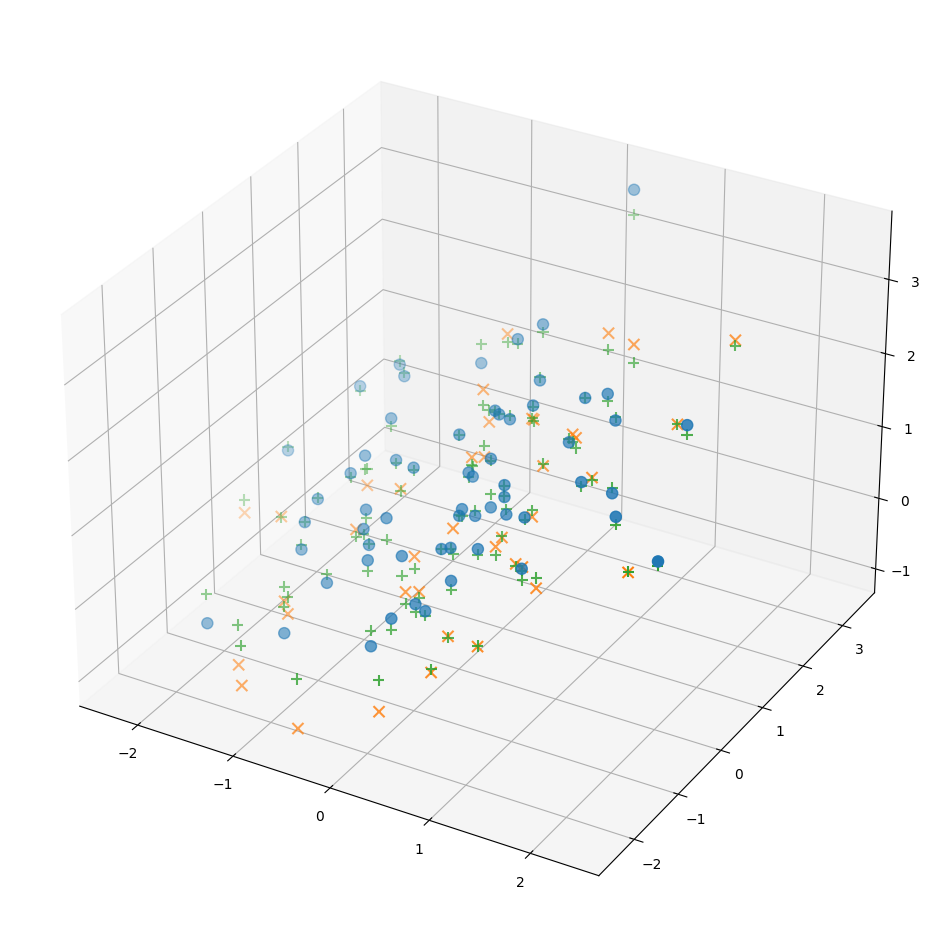

In [2]:
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate data
x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=2,
                                       bias=100.0,
                                       noise=10.0,
                                       random_state=201188)
y /= 100.0

# partition into train and validation subsets
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,
                                                                              y,
                                                                              test_size=40,
                                                                              random_state=221882)

# package training and validation data into tensorflow Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(10)

# set regularization factor
reg_fact = 0.01

# build model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_fact), input_shape=[2]))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_fact)))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_fact)))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

# fit model
model.fit(train_data, epochs=500, validation_data=valid_data)

# predict using fitted model
y_hat = model.predict(x)

# plot data and model fit
fig = plt.figure(figsize=(12,12))
axs = fig.add_subplot(projection='3d')
axs.scatter(train_x[:,0], train_x[:,1], train_y, marker='o', s=64)
axs.scatter(valid_x[:,0], valid_x[:,1], valid_y, marker='x', s=64)
axs.scatter(x[:,0], x[:,1], y_hat, marker='+', s=64)

It's important to note that, with regularization, the "loss" and "val_loss" reported by tensorflow during training *includes* the regularization penalty, so you *can't* directly compare the loss and val_loss values between models with/without regularization, or between models using different *types* or *strengths* of regularization!

The loss and val_loss will *always* be larger with regularization than without.

Well, what do you think; did L1 regularization reduce model overfitting in this example? Was the model's final loss value 'close to' the final val_loss?

Take some time to try out different values for "reg_fact". How small can you make the regularization factor, while still mitigating model overfitting?

In many cases, you don't need much regularization to prevent a model from overfitting, especially if the model has a large number of parameters and you apply regularization penalties to most of them.

Of course, you can 'turn off' regularization by setting:

    reg_fact = 0.0

in the previous code cell.



## implementing L2 kernel regularization

Now let's try L2 regularization.

Tensorflow L2 regularization is implemented by a tf.keras.regularizers.L2 object, so we'll need to change L1 to L2 in order to apply L2 regularization to the neural network's weights.

We'll also have to change the:

    l1=reg_fact

option to:

    l2=reg_fact

for the L2 regularizer. This is an unfortunate design choice made by tensorflow; it would have been better to use the *same* option name for *both* L1 and L2 regularization objects, but it is what it is.

Modyfy the "FIXME" portions of the following code cell to use L2 regularization, and then run it to see how L2 regularization helps mitigate model overfitting.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                192       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8577 (33.50 KB)
Trainable params: 8577 (33.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
6/6 [==============================] - 1s 49ms/step - loss: 3.1252 - val_loss: 2.8356
Epoch 2/500
6/6 [==============================] - 0s 

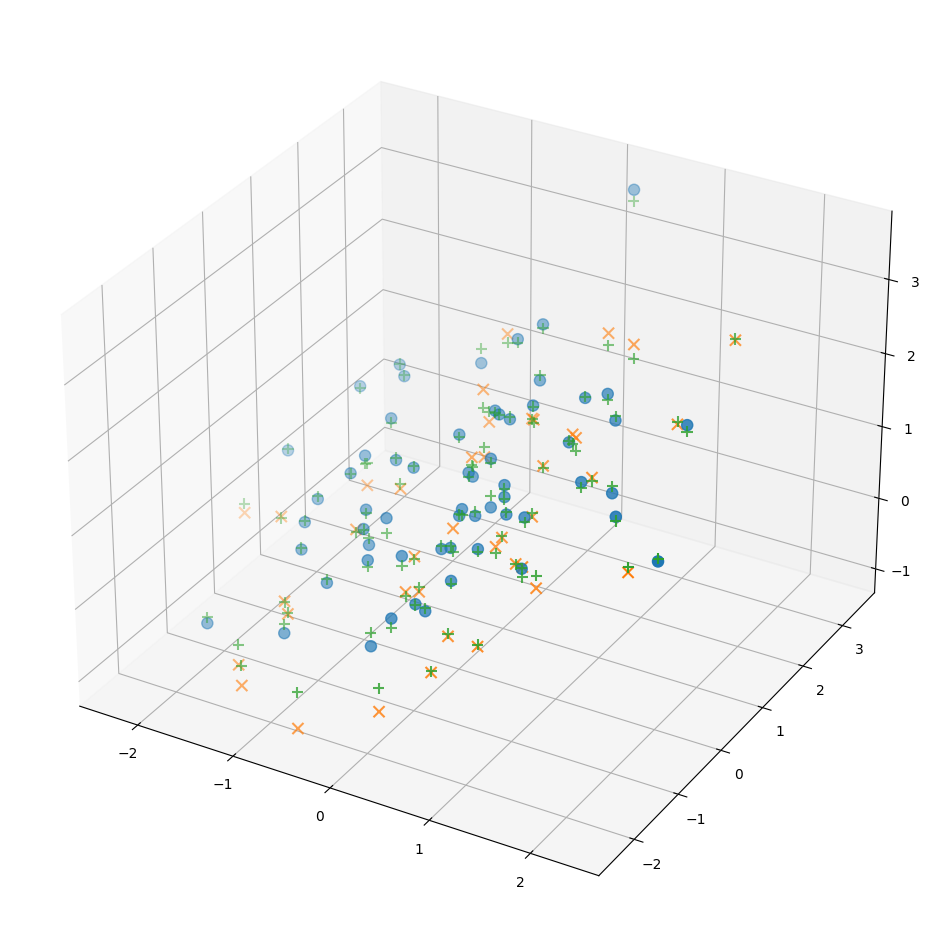

In [3]:
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import tensorflow as tf

# simulate data
x,y = sklearn.datasets.make_regression(n_samples=100,
                                       n_features=2,
                                       bias=100.0,
                                       noise=10.0,
                                       random_state=201188)
y /= 100.0

# partition into train and validation subsets
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(x,
                                                                              y,
                                                                              test_size=40,
                                                                              random_state=221882)

# package training and validation data into tensorflow Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(10)
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).batch(10)

# set regularization factor
reg_fact = 0.01

# build model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(l2=reg_fact), input_shape=[2]))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(l2=reg_fact)))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(l2=reg_fact)))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.MeanSquaredError())
model.summary()

# fit model
model.fit(train_data, epochs=500, validation_data=valid_data)

# predict using fitted model
y_hat = model.predict(x)

# plot data and model fit
fig = plt.figure(figsize=(12,12))
axs = fig.add_subplot(projection='3d')
axs.scatter(train_x[:,0], train_x[:,1], train_y, marker='o', s=64)
axs.scatter(valid_x[:,0], valid_x[:,1], valid_y, marker='x', s=64)
axs.scatter(x[:,0], x[:,1], y_hat, marker='+', s=64)

Make note of the final loss and val_loss values using L2 regularization with a regularization factor of 0.01; you may need these for the associated quiz!

After completing the quiz, I encourage you to take some time to play around with L2 regularization factors. How small can you make the regularization factor while still mitigating model overfitting?

Of course, you should resist the temptation to directly compare the regularization factors, loss and val_loss values from L1 vs L2 regularization!

In general, we would like model regularization to effectively mitigate model overfitting while having a minimal impact on the model's loss (and val_loss).